In [ ]:
!ls /kaggle/input/notebooks/kagglertw/local-data/dal-shemagh-detection-challenge

images	labels	train_labels.csv


In [ ]:
import os
import json
import pandas as pd
from PIL import Image
from tqdm import tqdm





DATASET_PATH = "/kaggle/input/notebooks/kagglertw/local-data/dal-shemagh-detection-challenge"

IMAGES_DIR = os.path.join(DATASET_PATH, "images/train")
LABELS_DIR = os.path.join(DATASET_PATH, "labels/train")
CSV_PATH = os.path.join(DATASET_PATH, "train_labels.csv")

OUTPUT_JSON = "/kaggle/working/train_coco.json"





df = pd.read_csv(CSV_PATH)


right_place_dict = dict(zip(df["filename"], df["right_place"]))








categories = [
    {"id": 0, "name": "head"},
    {"id": 1, "name": "shemagh"},
]





coco_output = {
    "images": [],
    "annotations": [],
    "categories": categories,
}

annotation_id = 0
image_id = 0





image_files = sorted(os.listdir(IMAGES_DIR))

for img_file in tqdm(image_files):

    if not img_file.endswith(".jpg"):
        continue

    img_path = os.path.join(IMAGES_DIR, img_file)
    label_path = os.path.join(LABELS_DIR, img_file.replace(".jpg", ".txt"))

    
    with Image.open(img_path) as img:
        width, height = img.size

    
    coco_output["images"].append({
        "id": image_id,
        "file_name": img_file,
        "width": width,
        "height": height,
        
        "right_place": bool(right_place_dict.get(img_file, False))
    })

    
    
    

    if os.path.exists(label_path):

        with open(label_path, "r") as f:
            lines = f.readlines()

        for line in lines:

            parts = line.strip().split()

            if len(parts) != 5:
                continue

            class_id, x_center, y_center, w, h = map(float, parts)

            

            x_center *= width
            y_center *= height
            w *= width
            h *= height

            x_min = x_center - (w / 2)
            y_min = y_center - (h / 2)

            coco_output["annotations"].append({
                "id": annotation_id,
                "image_id": image_id,
                "category_id": int(class_id),
                "bbox": [x_min, y_min, w, h],
                "area": w * h,
                "iscrowd": 0
            })

            annotation_id += 1

    image_id += 1





with open(OUTPUT_JSON, "w") as f:
    json.dump(coco_output, f)

print("✅ COCO JSON saved at:", OUTPUT_JSON)


100%|██████████| 651/651 [00:09<00:00, 66.32it/s]

✅ COCO JSON saved at: /kaggle/working/train_coco.json


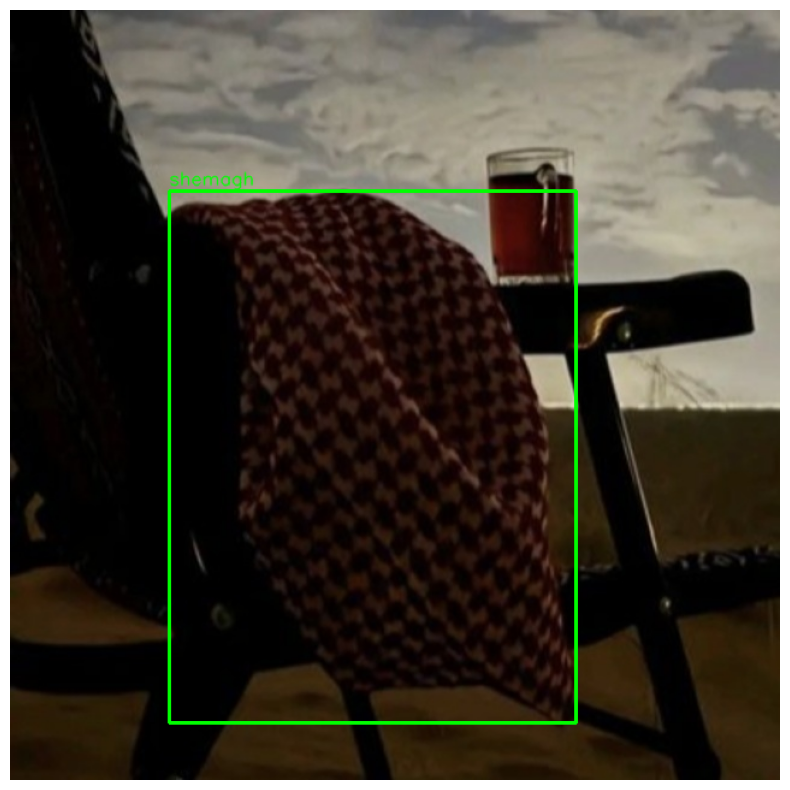

In [ ]:
import cv2
import json
import matplotlib.pyplot as plt
import os






def load_coco_annotations(json_path):

    with open(json_path, "r") as f:
        coco = json.load(f)

    
    images_dict = {img["id"]: img for img in coco["images"]}

    annotations_by_image = {}

    for ann in coco["annotations"]:
        img_id = ann["image_id"]
        annotations_by_image.setdefault(img_id, []).append(ann)

    categories = {cat["id"]: cat["name"] for cat in coco["categories"]}

    return images_dict, annotations_by_image, categories






def draw_annotations(image, annotations, categories):

    predefined_colors = [
        (255,0,0),
        (0,255,0),
        (0,0,255),
        (255,255,0),
        (255,0,255),
        (0,255,255),
    ]

    img = image.copy()

    for ann in annotations:

        x, y, w, h = ann["bbox"]
        class_id = ann["category_id"]

        color = predefined_colors[class_id % len(predefined_colors)]

        x1 = int(x)
        y1 = int(y)
        x2 = int(x + w)
        y2 = int(y + h)

        cv2.rectangle(img, (x1,y1), (x2,y2), color, 2)

        label = categories.get(class_id, str(class_id))

        cv2.putText(
            img,
            label,
            (x1, y1-5),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            color,
            1,
            cv2.LINE_AA
        )

    return img






def visualize_image(image_id, coco_json, images_dir):

    images_dict, annotations_by_image, categories = load_coco_annotations(coco_json)

    if image_id not in images_dict:
        print("Image ID not found.")
        return

    img_info = images_dict[image_id]

    img_path = os.path.join(images_dir, img_info["file_name"])

    image = cv2.imread(img_path)

    if image is None:
        print("Failed to load image.")
        return

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    anns = annotations_by_image.get(image_id, [])

    image_drawn = draw_annotations(image, anns, categories)

    plt.figure(figsize=(10,10))
    plt.imshow(image_drawn)
    plt.axis("off")
    plt.show()






def main():

    coco_json = "/kaggle/working/train_coco.json"
    images_dir = "/kaggle/input/notebooks/kagglertw/local-data/dal-shemagh-detection-challenge/images/train"

    
    visualize_image(
        image_id=7,
        coco_json=coco_json,
        images_dir=images_dir
    )


if __name__ == "__main__":
    main()
